In [ ]:
# https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
# https://www.kaggle.com/arunmohan003/fasterrcnn-using-pytorch-baseline
# https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train

In [8]:
import glob

frac_imgs_path = glob.glob('./Scaphoid/Images/Fracture/*')
norm_imgs_path = glob.glob('./Scaphoid/Images/Normal/*')
frac_cord_path = glob.glob('./Scaphoid/Annotations/Fracture_Coordinate/*')
slice_path = glob.glob('./Scaphoid/Annotations/Scaphoid_Slice/*') # json 檔

print(len(frac_imgs_path), len(norm_imgs_path), len(frac_cord_path), len(slice_path))
# print(frac_imgs_path[:5])

120 120 120 240


In [9]:
import pandas as pd
import json
import numpy as np
import os
df = pd.DataFrame(columns = ['img_id' , 'x1', 'y1', 'x2', 'y2'])
for i in slice_path:
    basename = os.path.basename(i)
    img_id = os.path.splitext(basename)[0]
    with open('./Scaphoid/Annotations/Scaphoid_Slice/' + img_id + '.json') as f:
        data_bbox = json.load(f)[0]['bbox']

    df = df.append({'img_id':img_id ,
                    'x1':float(data_bbox[0]), 
                    'y1':float(data_bbox[1]), 
                    'x2':float(data_bbox[2]), 
                    'y2':float(data_bbox[3])} , ignore_index=True)
print(len(df))
df.head()

240


,img_id,x1,y1,x2,y2
0,00075616-AP0,751.0,794.0,873.0,945.0
1,00169382 L 51F AP0,679.0,842.0,823.0,984.0
2,00230304 R 50F AP0,867.0,943.0,1007.0,1092.0
3,00293717 L 77M AP0,663.0,912.0,856.0,1091.0
4,00454212-LOB0,585.0,996.0,776.0,1189.0


In [10]:
from albumentations.pytorch.transforms import ToTensorV2
from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip, Normalize, Flip,
                            Compose, GaussNoise)
# Albumentations
def get_train_transform():
    return Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


In [4]:
from lib import transform as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


ImportError: cannot import name 'transform' from 'lib' (unknown location)

In [12]:
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
class HandDataset(Dataset):
    def __init__(self, data_frame, transforms) -> None:
        super().__init__()
        self.df = data_frame
        self.images = data_frame['img_id']
        # print(len(self.images))
        self.transforms = transforms
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # print(idx, self.images[idx])
        
        image_filename = str(self.images[idx]) + '.bmp'
        # print(image_filename)
        if os.path.exists('./Scaphoid/Images/Fracture/' + image_filename): # 在 Fracture 的資料夾中
            image_arr = cv2.imread('./Scaphoid/Images/Fracture/' + image_filename, cv2.IMREAD_COLOR)
        elif os.path.exists('./Scaphoid/Images/Normal/' + image_filename): # 在 Normal 的資料夾中
            image_arr = cv2.imread('./Scaphoid/Images/Normal/' + image_filename, cv2.IMREAD_COLOR)
        else:
            print("Error Loading img")
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32) 
        image_arr /= 255.0

        image_id = self.images[idx]
        point = self.df[self.df['img_id'] == image_id]
        boxes = point[['x1', 'y1', 'x2', 'y2']].values        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # 有改這個
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((point.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((point.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['img_id'] = torch.tensor(idx)
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transforms:
            sample = {
                'image': image_arr,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
        target['boxes'] = torch.stack(tuple(map(torch.tensor, 
                                                zip(*sample['bboxes'])))).permute(1, 0)
        
        return image, target, image_id


In [6]:
train_data = HandDataset(df[:20], get_train_transform())
val = df[220:]
val.reset_index(inplace=True, drop=True)
val_data = HandDataset(val, get_valid_transform())

# batching
def collate_fn(batch):
    return tuple(zip(*batch))


train_data_loader = DataLoader(
    train_data,
    batch_size=4,
    shuffle=False,
    # num_workers=1,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    val_data,
    batch_size=4,
    shuffle=False,
    # num_workers=1,
    collate_fn=collate_fn
)


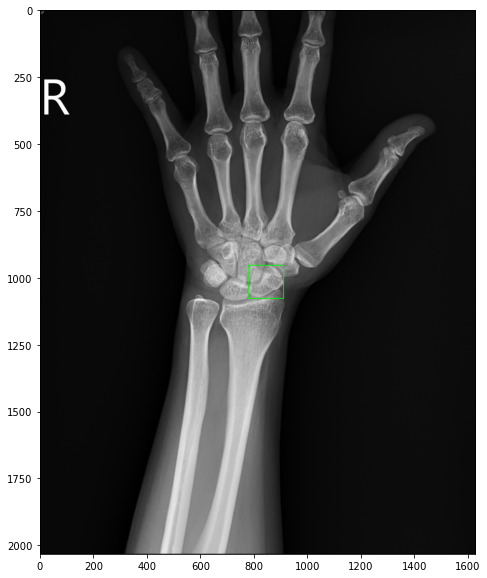

In [7]:
import matplotlib.pyplot as plt
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(data, idx):
    out = data.__getitem__(idx)
    image = image_convert(out[0])
    image = np.ascontiguousarray(image)
    bb = out[1]['boxes'].numpy()
    for i in bb:
        cv2.rectangle(image, (int(i[0]),int(i[1])), (int(i[2]),int(i[3])), (0,255,0), thickness=2)
    plt.figure(figsize=(10,10))
    plt.imshow(image)

plot_img(val_data, 2)


In [7]:
val_data[0]

(tensor([[[0.0353, 0.0353, 0.0353,  ..., 0.0314, 0.0000, 0.0000],
          [0.0353, 0.0353, 0.0353,  ..., 0.0353, 0.0000, 0.0000],
          [0.0353, 0.0353, 0.0353,  ..., 0.0314, 0.0000, 0.0000],
          ...,
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0000, 0.0000],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0353, 0.0353, 0.0353,  ..., 0.0314, 0.0000, 0.0000],
          [0.0353, 0.0353, 0.0353,  ..., 0.0353, 0.0000, 0.0000],
          [0.0353, 0.0353, 0.0353,  ..., 0.0314, 0.0000, 0.0000],
          ...,
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0000, 0.0000],
          [0.0118, 0.0118, 0.0118,  ..., 0.0118, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0353, 0.0353, 0.0353,  ..., 0.0314, 0.0000, 0.0000],
          [0.0353, 0.0353, 0.0353,  ..., 0.0353, 0.0000, 0.0000],
          [0.0353, 0.0353, 0.0353,  ...,

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def get_model_instance_segmentation(num_classes):
    # load a model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # num_classes which is user-defined
    num_classes = 2  # 1 class (person) + background
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


## main function

In [8]:
from lib import egine

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = get_model_instance_segmentation(num_classes=2)
model.to(device)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)
# num_epochs = 1

# for epoch in range(num_epochs):
#     # train for one epoch, printing every 10 iterations
#     egine.train_one_epoch(model, optimizer, train_data_loader, device, epoch)
#     # update the learning rate
#     lr_scheduler.step()
#     # evaluate on the test dataset
#     egine.evaluate(model, valid_data_loader, device=device)

# print("That's it!")
# torch.save(model.state_dict(), 'engine_fasterrcnn_resnet50_fpn.pth')


C:\Users\Ming\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\cuda\__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
import time
from tqdm import tqdm
num_epochs = 1
train_loss_min = 0.9
total_train_loss = []


checkpoint_path = '/save/chkpoint_'
best_model_path = '/save/bestmodel_may12.pt'

for epoch in range(num_epochs):
    print(f'Epoch :{epoch + 1}')
    start_time = time.time()
    train_loss = []
    model.train()
    for images, targets, image_ids in tqdm(train_data_loader):
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        train_loss.append(losses.item())        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    #train_loss/len(train_data_loader.dataset)
    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
    print(f'Epoch train loss is {epoch_train_loss}')
    
    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')



In [9]:
pred_model = get_model_instance_segmentation(num_classes=2)
pred_model.load_state_dict(torch.load('fasterrcnn_resnet50_fpn_cloud_1216.pth', map_location='cpu'))
# model.load_state_dict(torch.load('model_state.pth', map_location='cpu'))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

pred_model.to(device) # For inference
pred_model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [17]:
from tqdm import tqdm

pred_list =[]
for images, targets, image_ids in tqdm(valid_data_loader):
    
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    prediction = pred_model(images, targets)
    
    for i in prediction:
        pred_list.append(i)




100%|██████████| 5/5 [04:15<00:00, 51.10s/it]


[[ 769.61224  950.135    915.72217 1074.9291 ]]


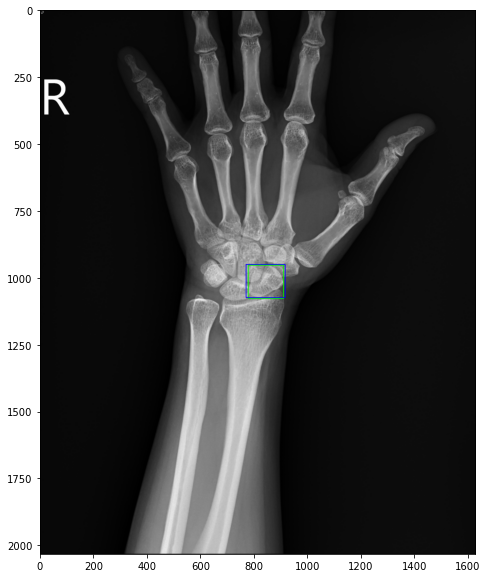

In [24]:
import matplotlib.pyplot as plt
prediction1 = pred_list
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def predict_plot_img(data, idx):
    out = data.__getitem__(idx)
    image = image_convert(out[0])
    image = np.ascontiguousarray(image)
    bb = out[1]['boxes'].numpy()
    for i in bb:
        cv2.rectangle(image, (int(i[0]),int(i[1])), (int(i[2]),int(i[3])), (0,255,0), thickness=2)
    bb = pred_list[idx]['boxes'].detach().numpy()
    print(bb)
    for i in bb:
        cv2.rectangle(image, (int(i[0]),int(i[1])), (int(i[2]),int(i[3])), (255,0,0), thickness=2)
    bb = prediction1[idx]['boxes'].detach().numpy()
    for i in bb:
        cv2.rectangle(image, (int(i[0]),int(i[1])), (int(i[2]),int(i[3])), (0,0,255), thickness=2)

    plt.figure(figsize=(10,10))
    plt.imshow(image)

predict_plot_img(val_data,2)
